In [1]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import importlib
import tensorflow as tf
import warnings

warnings.filterwarnings('ignore')
from tensorflow.keras.models import load_model

import Model
importlib.reload(Model)

def visualize_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Plot Loss (Train & Validation)
    axs[0].plot(history.history['loss'], label='Train Loss', marker='o', markersize=4)
    axs[0].plot(history.history['val_loss'], label='Val Loss', marker='*', markersize=4)
    axs[0].set_title('Model Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # Plot Accuracy (Train & Validation)
    axs[1].plot(history.history['accuracy'], label='Train Accuracy', marker='o', markersize=4)
    axs[1].plot(history.history['val_accuracy'], label='Val Accuracy', marker='*', markersize=4)
    axs[1].set_title('Model Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

def get_dataset(path, classes, show_labels):
    for c_idx, c in enumerate(classes):
        raw_data = os.listdir(path+c)
        if len(raw_data) == 1:
            mat = scipy.io.loadmat(path+c+raw_data[0])
        else:
            print("There is more than one dataset - check")

        if c_idx == 0:
            print(f"Import matlab raw dataset - Matlab file Keys: {mat.keys()}")
            #pass

        if mat['Data_Cls'].shape[-1] != mat['Data_Fea'].shape[-1]:
            print(f"Label and dataset do not match! : {len(mat['Data_Cls'])}, {len(mat['Data_Fea'])}")
            break

        if c_idx == 0:
            feature_set = np.transpose(mat['Data_Fea'], (2, 0, 1))  # shape: (1729, 4, 14)
            labels = mat['Data_Cls'].flatten()  #0 or class (either one)

        elif c_idx > 0:
            feature_set_added = np.transpose(mat['Data_Fea'], (2, 0, 1))
            labels_addend = mat['Data_Cls'].flatten()  #0 or class (either one)

            feature_set = np.concatenate([feature_set, feature_set_added], axis=0)
            labels = np.concatenate([labels, labels_addend], axis=0)
        else:
            print("Error in c_idx")
            break

    if show_labels:
        plt.figure(figsize=(8,3))
        plt.plot(labels)
        plt.ylabel('Class label', fontsize=13)
        plt.xlabel('Samples', fontsize=13)
        plt.grid(True, which='both', linestyle='--')
        plt.show()

    return feature_set, labels


def split_data(X, Y, ratio):
    #Splits (N, C, F) data and 1D labels into training and validation sets.

    num_samples = X.shape[0]
    indices = np.random.permutation(num_samples)

    training_size = int(round(num_samples * ratio))
    training_indices = indices[:training_size]
    validation_indices = indices[training_size:]

    training_data = X[training_indices]
    training_labels = Y[training_indices]
    validation_data = X[validation_indices]
    validation_labels = Y[validation_indices]

    training_data = np.expand_dims(training_data, axis=-1)  # Adds a new channel dimension at the end
    validation_data = np.expand_dims(validation_data, axis=-1)

    return training_data, training_labels, validation_data, validation_labels


def Continual_Learning_Init_stage(X_train, y_train, model, batch_size):

    # Save weights of Task A as tf.Tensors (not numpy)
    weights_task = [tf.identity(var) for var in model.trainable_variables]

    # Compute importance via squared gradients
    importance = [tf.zeros_like(var) for var in model.trainable_variables]
    batch = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)

    for x_batch, y_batch in batch:
        with tf.GradientTape() as tape:
            preds = model(x_batch)
            loss = tf.keras.losses.sparse_categorical_crossentropy(y_batch, preds)
        grads = tape.gradient(loss, model.trainable_variables)
        for i, grad in enumerate(grads):
            if grad is not None:
                importance[i] += tf.square(grad)
    importance = [imp / len(batch) for imp in importance]

    return weights_task, importance



def Continual_Learning_adaptation_stage(X_train, y_train, X_test, y_test, X_test_prev, y_test_prev, model,
                                        weights_prev_task, importance, number_epochs, batch_size):

    # 5. Fine-tune on Task B with EWC regularization
    lambda_ewc = 1000.0  # importance regularization strength
    optimizer = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)


    acc_init = model.evaluate(X_test, y_test, verbose=0)[1]
    # Custom training loop with EWC
    for epoch in range(number_epochs):
        print(f"Epoch {epoch + 1}")
        for step, (x_batch, y_batch) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                preds = model(x_batch, training=True)
                loss = loss_fn(y_batch, preds)
                # EWC regularization
                for var, old_w, imp in zip(model.trainable_variables, weights_prev_task, importance):
                    loss += (lambda_ewc / 2) * tf.reduce_sum(imp * tf.square(var - old_w))
            grads = tape.gradient(loss, best_model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # === Evaluate after Task B training with EWC ===
    print("\n✅ Evaluation after Task B training (EWC fine-tuning):")
    acc_prev_data = model.evaluate(X_test_prev, y_test_prev, verbose=0)[1]
    acc_current_stage = model.evaluate(X_test, y_test, verbose=0)[1]
    print(f"Accuracy on Previous Task: {acc_prev_data:.4f}  ← Should remain high if EWC works")
    print(f"Accuracy on Current Task: {acc_current_stage:.4f}")

    return acc_init, acc_prev_data, acc_current_stage

In [2]:
default_path = "C:/Users/hml76/OneDrive/문서/MATLAB/data/"
classes = ['1/','2/','3/','4/','5/']
version = 'V1'

Info = ['Stand (5/27)', 'Stand (6/18)', 'Stand (6/20)', 'Sit_chair (6/20)', 'Sit_chair_leg_crossed (6/20)', 'Sit_floor (6/20)',
        'Stand (6/20-v2)', 'Sit_chair (6/20-v2)', 'Sit_chair_leg_crossed (6/20-v2)', 'Sit_floor (6/20-v2)']


importlib.reload(Model)
best_model = load_model(f'best_model_{version}.keras')

train_ratio = 0.5

In [3]:
path = default_path + 'Exp_2025-05-27/E8331D05289A/raw/'

feature_set, labels = get_dataset(path, classes, show_labels=False)
X_train, y_train, X_test_init, y_test_init = split_data(feature_set, labels, ratio=train_ratio)
val_loss, val_acc = best_model.evaluate(X_test_init, y_test_init)

Init_acc_all, Prev_acc_all, Trained_acc_all = [0.2], [val_acc], [val_acc]

Import matlab raw dataset - Matlab file Keys: dict_keys(['__header__', '__version__', '__globals__', 'Data_ADC', 'Data_Cls', 'Data_Fea', 'Dev_Channels', 'Dev_Info', 'Dev_NCh'])
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9406 - loss: 0.1769


In [4]:
number_epochs = 5
batch_size = 64

weights_task_init, importance_init = Continual_Learning_Init_stage(X_train, y_train, best_model, batch_size)

In [5]:
session_info = "Exp_2025-06-18"
path = default_path + f'{session_info}/E9AD0E7DCC2B/raw/'

feature_set, labels = get_dataset(path, classes, show_labels=False)
X_train, y_train, X_test_new, y_test_new = split_data(feature_set, labels, ratio=train_ratio)

X_test_prev_all = np.concatenate((X_test_init, X_test_new), axis=0)
y_test_prev_all = np.concatenate((y_test_init, y_test_new), axis=0)
#print(X_test_prev_all.shape, y_test_prev_all.shape, X_test_init.shape, X_test_new.shape)

init, prev, current = Continual_Learning_adaptation_stage(X_train, y_train, X_test_new, y_test_new, X_test_prev_all, y_test_prev_all, best_model,
                                        weights_task_init, importance_init, number_epochs, batch_size)

Init_acc_all.append(init)
Prev_acc_all.append(prev)
Trained_acc_all.append(current)

Import matlab raw dataset - Matlab file Keys: dict_keys(['__header__', '__version__', '__globals__', 'Data_ADC', 'Data_Cls', 'Data_Fea', 'Dev_Channels', 'Dev_Info', 'Dev_NCh'])
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5

✅ Evaluation after Task B training (EWC fine-tuning):
Accuracy on Previous Task: 0.8951  ← Should remain high if EWC works
Accuracy on Current Task: 0.8576


In [6]:
session_info = "Exp_2025-06-20-v1"
path = default_path + f'{session_info}/E9AD0E7DCC2B/raw/'

feature_set, labels = get_dataset(path, classes, show_labels=False)
X_train, y_train, X_test_new, y_test_new = split_data(feature_set, labels, ratio=train_ratio)

X_test_prev_all = np.concatenate((X_test_init, X_test_new), axis=0)
y_test_prev_all = np.concatenate((y_test_init, y_test_new), axis=0)
#print(X_test_prev_all.shape, y_test_prev_all.shape, X_test_init.shape, X_test_new.shape)

init, prev, current = Continual_Learning_adaptation_stage(X_train, y_train, X_test_new, y_test_new, X_test_prev_all, y_test_prev_all, best_model,
                                        weights_task_init, importance_init, number_epochs, batch_size)

Init_acc_all.append(init)
Prev_acc_all.append(prev)
Trained_acc_all.append(current)

Import matlab raw dataset - Matlab file Keys: dict_keys(['__header__', '__version__', '__globals__', 'Data_ADC', 'Data_Cls', 'Data_Fea', 'Dev_Channels', 'Dev_Info', 'Dev_NCh'])
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5

✅ Evaluation after Task B training (EWC fine-tuning):
Accuracy on Previous Task: 0.8969  ← Should remain high if EWC works
Accuracy on Current Task: 0.8558


In [7]:
session_info = "Exp_2025-06-20-v2"
path = default_path + f'{session_info}/E9AD0E7DCC2B/raw/'

feature_set, labels = get_dataset(path, classes, show_labels=False)
X_train, y_train, X_test_new, y_test_new = split_data(feature_set, labels, ratio=train_ratio)

X_test_prev_all = np.concatenate((X_test_init, X_test_new), axis=0)
y_test_prev_all = np.concatenate((y_test_init, y_test_new), axis=0)
#print(X_test_prev_all.shape, y_test_prev_all.shape, X_test_init.shape, X_test_new.shape)

init, prev, current = Continual_Learning_adaptation_stage(X_train, y_train, X_test_new, y_test_new, X_test_prev_all, y_test_prev_all, best_model,
                                        weights_task_init, importance_init, number_epochs, batch_size)

Init_acc_all.append(init)
Prev_acc_all.append(prev)
Trained_acc_all.append(current)

Import matlab raw dataset - Matlab file Keys: dict_keys(['__header__', '__version__', '__globals__', 'Data_ADC', 'Data_Cls', 'Data_Fea', 'Dev_Channels', 'Dev_Info', 'Dev_NCh'])
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5

✅ Evaluation after Task B training (EWC fine-tuning):
Accuracy on Previous Task: 0.9208  ← Should remain high if EWC works
Accuracy on Current Task: 0.9057


In [8]:
session_info = "Exp_2025-06-20-v3"
path = default_path + f'{session_info}/E9AD0E7DCC2B/raw/'

feature_set, labels = get_dataset(path, classes, show_labels=False)
X_train, y_train, X_test_new, y_test_new = split_data(feature_set, labels, ratio=train_ratio)

X_test_prev_all = np.concatenate((X_test_init, X_test_new), axis=0)
y_test_prev_all = np.concatenate((y_test_init, y_test_new), axis=0)
#print(X_test_prev_all.shape, y_test_prev_all.shape, X_test_init.shape, X_test_new.shape)

init, prev, current = Continual_Learning_adaptation_stage(X_train, y_train, X_test_new, y_test_new, X_test_prev_all, y_test_prev_all, best_model,
                                        weights_task_init, importance_init, number_epochs, batch_size)

Init_acc_all.append(init)
Prev_acc_all.append(prev)
Trained_acc_all.append(current)

Import matlab raw dataset - Matlab file Keys: dict_keys(['__header__', '__version__', '__globals__', 'Data_ADC', 'Data_Cls', 'Data_Fea', 'Dev_Channels', 'Dev_Info', 'Dev_NCh'])
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5

✅ Evaluation after Task B training (EWC fine-tuning):
Accuracy on Previous Task: 0.9186  ← Should remain high if EWC works
Accuracy on Current Task: 0.8998


In [9]:
session_info = "Exp_2025-06-20-v4"
path = default_path + f'{session_info}/E9AD0E7DCC2B/raw/'

feature_set, labels = get_dataset(path, classes, show_labels=False)
X_train, y_train, X_test_new, y_test_new = split_data(feature_set, labels, ratio=train_ratio)

X_test_prev_all = np.concatenate((X_test_init, X_test_new), axis=0)
y_test_prev_all = np.concatenate((y_test_init, y_test_new), axis=0)
#print(X_test_prev_all.shape, y_test_prev_all.shape, X_test_init.shape, X_test_new.shape)

init, prev, current = Continual_Learning_adaptation_stage(X_train, y_train, X_test_new, y_test_new, X_test_prev_all, y_test_prev_all, best_model,
                                        weights_task_init, importance_init, number_epochs, batch_size)

Init_acc_all.append(init)
Prev_acc_all.append(prev)
Trained_acc_all.append(current)

Import matlab raw dataset - Matlab file Keys: dict_keys(['__header__', '__version__', '__globals__', 'Data_ADC', 'Data_Cls', 'Data_Fea', 'Dev_Channels', 'Dev_Info', 'Dev_NCh'])
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5

✅ Evaluation after Task B training (EWC fine-tuning):
Accuracy on Previous Task: 0.8501  ← Should remain high if EWC works
Accuracy on Current Task: 0.7733


In [10]:
session_info = "Exp_2025-06-20-v5"
path = default_path + f'{session_info}/E9AD0E7DCC2B/raw/'

feature_set, labels = get_dataset(path, classes, show_labels=False)
X_train, y_train, X_test_new, y_test_new = split_data(feature_set, labels, ratio=train_ratio)

X_test_prev_all = np.concatenate((X_test_init, X_test_new), axis=0)
y_test_prev_all = np.concatenate((y_test_init, y_test_new), axis=0)
#print(X_test_prev_all.shape, y_test_prev_all.shape, X_test_init.shape, X_test_new.shape)

init, prev, current = Continual_Learning_adaptation_stage(X_train, y_train, X_test_new, y_test_new, X_test_prev_all, y_test_prev_all, best_model,
                                        weights_task_init, importance_init, number_epochs, batch_size)

Init_acc_all.append(init)
Prev_acc_all.append(prev)
Trained_acc_all.append(current)

Import matlab raw dataset - Matlab file Keys: dict_keys(['__header__', '__version__', '__globals__', 'Data_ADC', 'Data_Cls', 'Data_Fea', 'Dev_Channels', 'Dev_Info', 'Dev_NCh'])
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5

✅ Evaluation after Task B training (EWC fine-tuning):
Accuracy on Previous Task: 0.8580  ← Should remain high if EWC works
Accuracy on Current Task: 0.8070


In [11]:
session_info = "Exp_2025-06-20-v6"
path = default_path + f'{session_info}/E9AD0E7DCC2B/raw/'

feature_set, labels = get_dataset(path, classes, show_labels=False)
X_train, y_train, X_test_new, y_test_new = split_data(feature_set, labels, ratio=train_ratio)

X_test_prev_all = np.concatenate((X_test_init, X_test_new), axis=0)
y_test_prev_all = np.concatenate((y_test_init, y_test_new), axis=0)
#print(X_test_prev_all.shape, y_test_prev_all.shape, X_test_init.shape, X_test_new.shape)

init, prev, current = Continual_Learning_adaptation_stage(X_train, y_train, X_test_new, y_test_new, X_test_prev_all, y_test_prev_all, best_model,
                                        weights_task_init, importance_init, number_epochs, batch_size)

Init_acc_all.append(init)
Prev_acc_all.append(prev)
Trained_acc_all.append(current)

Import matlab raw dataset - Matlab file Keys: dict_keys(['__header__', '__version__', '__globals__', 'Data_ADC', 'Data_Cls', 'Data_Fea', 'Dev_Channels', 'Dev_Info', 'Dev_NCh'])
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5

✅ Evaluation after Task B training (EWC fine-tuning):
Accuracy on Previous Task: 0.8760  ← Should remain high if EWC works
Accuracy on Current Task: 0.8221


In [12]:
session_info = "Exp_2025-06-20-v7"
path = default_path + f'{session_info}/E9AD0E7DCC2B/raw/'

feature_set, labels = get_dataset(path, classes, show_labels=False)
X_train, y_train, X_test_new, y_test_new = split_data(feature_set, labels, ratio=train_ratio)

X_test_prev_all = np.concatenate((X_test_init, X_test_new), axis=0)
y_test_prev_all = np.concatenate((y_test_init, y_test_new), axis=0)
#print(X_test_prev_all.shape, y_test_prev_all.shape, X_test_init.shape, X_test_new.shape)

init, prev, current = Continual_Learning_adaptation_stage(X_train, y_train, X_test_new, y_test_new, X_test_prev_all, y_test_prev_all, best_model,
                                        weights_task_init, importance_init, number_epochs, batch_size)

Init_acc_all.append(init)
Prev_acc_all.append(prev)
Trained_acc_all.append(current)

Import matlab raw dataset - Matlab file Keys: dict_keys(['__header__', '__version__', '__globals__', 'Data_ADC', 'Data_Cls', 'Data_Fea', 'Dev_Channels', 'Dev_Info', 'Dev_NCh'])
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5

✅ Evaluation after Task B training (EWC fine-tuning):
Accuracy on Previous Task: 0.8714  ← Should remain high if EWC works
Accuracy on Current Task: 0.8303


In [13]:
session_info = "Exp_2025-06-20-v8"
path = default_path + f'{session_info}/E9AD0E7DCC2B/raw/'

feature_set, labels = get_dataset(path, classes, show_labels=False)
X_train, y_train, X_test_new, y_test_new = split_data(feature_set, labels, ratio=train_ratio)

X_test_prev_all = np.concatenate((X_test_init, X_test_new), axis=0)
y_test_prev_all = np.concatenate((y_test_init, y_test_new), axis=0)
#print(X_test_prev_all.shape, y_test_prev_all.shape, X_test_init.shape, X_test_new.shape)

init, prev, current = Continual_Learning_adaptation_stage(X_train, y_train, X_test_new, y_test_new, X_test_prev_all, y_test_prev_all, best_model,
                                        weights_task_init, importance_init, number_epochs, batch_size)

Init_acc_all.append(init)
Prev_acc_all.append(prev)
Trained_acc_all.append(current)

Import matlab raw dataset - Matlab file Keys: dict_keys(['__header__', '__version__', '__globals__', 'Data_ADC', 'Data_Cls', 'Data_Fea', 'Dev_Channels', 'Dev_Info', 'Dev_NCh'])
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5

✅ Evaluation after Task B training (EWC fine-tuning):
Accuracy on Previous Task: 0.8712  ← Should remain high if EWC works
Accuracy on Current Task: 0.8606


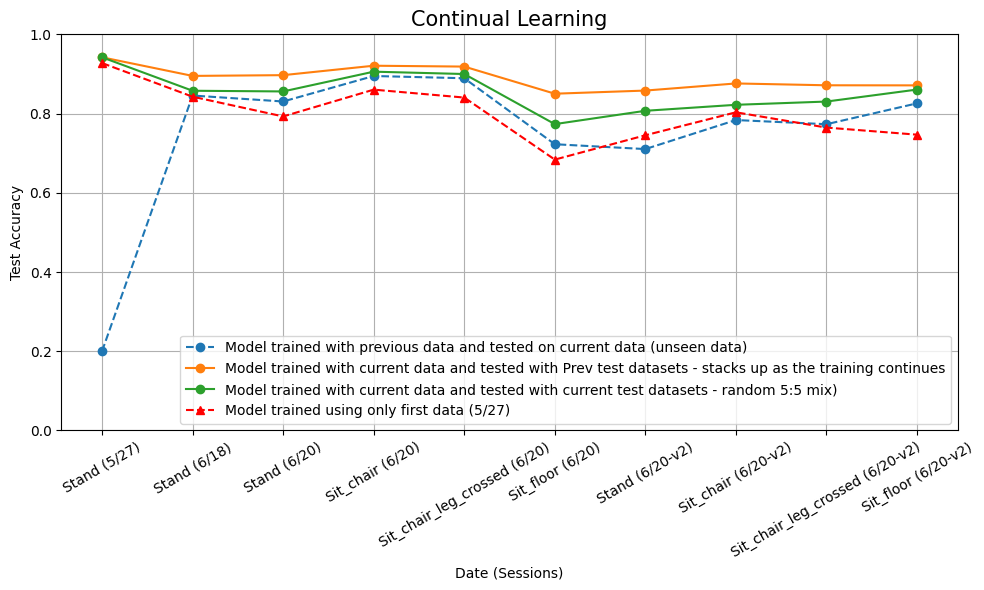

In [23]:
baseline = [0.9275, 0.8426, 0.7927, 0.8604, 0.8404, 0.6838, 0.7452, 0.8032, 0.7646, 0.7467]

plt.figure(figsize=(10, 6))
plt.title('Continual Learning', fontsize=15)

plt.plot(Info, Init_acc_all, marker='o', label='Model trained with previous data and tested on current data (unseen data)', linestyle='--')
plt.plot(Info, Prev_acc_all, marker='o', label='Model trained with current data and tested with Prev test datasets - stacks up as the training continues')
plt.plot(Info, Trained_acc_all, marker='o', label='Model trained with current data and tested with current test datasets - random 5:5 mix)')
plt.plot(Info, baseline, marker='^', label='Model trained using only first data (5/27)', color='red', linestyle='--')

plt.ylim([0, 1])
plt.xlabel('Date (Sessions)')
plt.ylabel('Test Accuracy')
plt.xticks(rotation=30)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
for x in [Init_acc_all, Prev_acc_all, Trained_acc_all]:
    print(f"{np.mean(x)*100:.2f}%")


74.75%
89.00%
85.54%


In [15]:
73.88%
88.91%
85.02%